# Importando bibliotecas

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM

warnings.simplefilter("ignore")

from matplotlib.pyplot import figure
from matplotlib import style
plt.style.use('seaborn')

In [2]:
# Separação do dado de treino e teste da série temporal original
corte_teste = 500

foward_days = 100 # quantidade de dias a frente que queremos prever
look_back = 100 # 2*foward_days # quantidade de passos de tempo que estamos olhando para trás para realizar a previsão (Em função do foward_days)

n_iterations = 5 # Quantos blocos a frente queremos prever, utilizando sempre a última predição como input

thr = 0.10 # Definindo o threshold

media_movel_flag = False # False = sem media movel / True = com média movel
media_movel_dias = 10 # quantos dias de média móvel 

Colocamos o look_back igual ao foward_days para garantirmos que o input da previsão seguinte será diferente do input anterior.
Imagina que a Random Forest cria uma função abstrata que modela o problema físico que estamos tentando resolver. Esta função será contínua. Mais ainda, será Lipschitziana. Logo, se apendarmos apenas um valor ao vetor de tamanho look_back, a função tenderá a ser contínua no longo tempo.
Exemplo: função que dada uma sequencia retorna a média da sequencia.

# Importando o dataset

In [3]:
data = pd.read_excel('Volve_production_data.xlsx')

In [4]:
# O vetor well_codes tem o nome de todos os poços
well_codes = list(data['WELL_BORE_CODE'].unique())

0 746


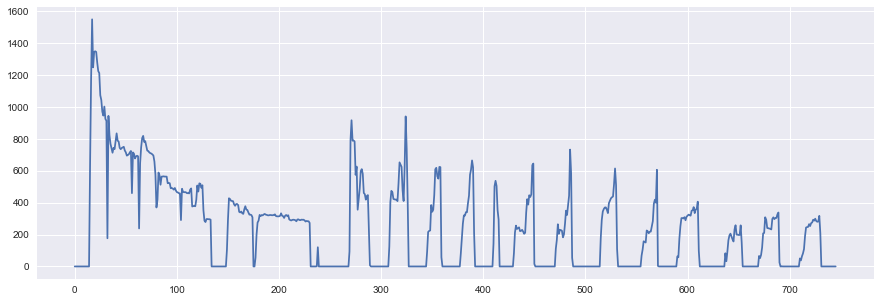

In [5]:
# Alterando o índice do vetor well_codes, conseguimos tratar outros poços
aux = data[data["WELL_BORE_CODE"]==well_codes[0]]
aux.sort_values(by='DATEPRD', ignore_index=True, inplace=True)
prod = aux['BORE_OIL_VOL']

# Verificando se possui dados missing
print(prod.isna().sum(), prod.shape[0])

plt.figure(figsize=(15, 5))
prod.plot()
plt.show()

In [6]:
prod_array = prod.values

In [7]:
# Calculando a média móvel

tam = prod_array.shape[0]

if media_movel_flag:
    media_movel_array = np.array([])
    
    for i in range(tam):
        
        if i > media_movel_dias:
            aux = np.mean(prod_array[i-media_movel_dias:i+media_movel_dias])
        else:
            for kk in range(media_movel_dias+1):
                aux = np.mean(prod_array[i-media_movel_dias+kk:i+media_movel_dias])
                if ~np.isnan(aux):
                    break
            
        media_movel_array = np.append(media_movel_array, aux)
else:
    media_movel_array = np.copy(prod_array)

In [8]:
print(prod_array.shape, media_movel_array.shape)

(746,) (746,)


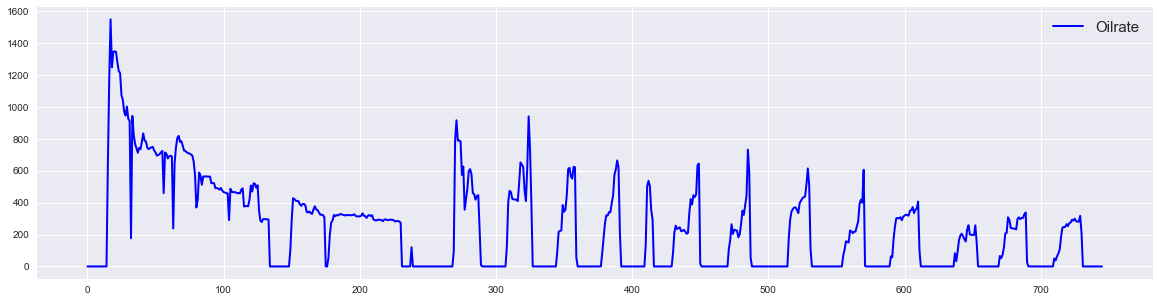

In [9]:
plt.figure(figsize=(20, 5))
#plt.plot(prod_array, 'r--', label='Real')
plt.plot(media_movel_array, 'b', linewidth=2, label='Oilrate')#'Média móvel de '+str(media_movel_dias)+' dias')
plt.legend(fontsize=15)
plt.show()

In [10]:
scaler = MinMaxScaler()

In [11]:
serie = media_movel_array.reshape(media_movel_array.shape[0], 1)

In [12]:
serie = scaler.fit_transform(serie)

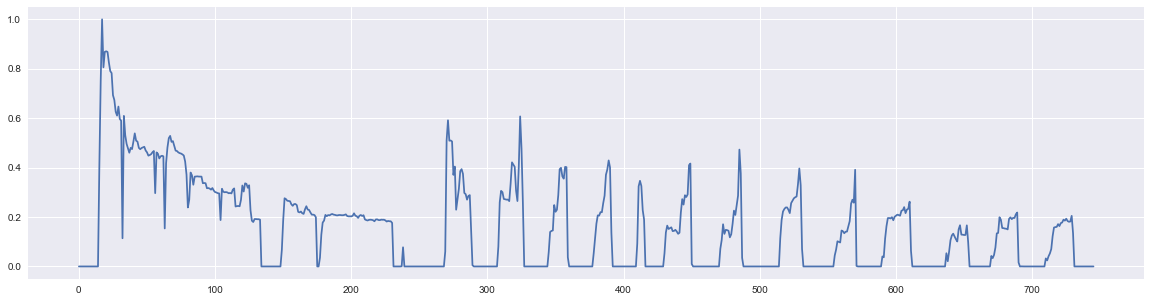

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(serie)
plt.show()

In [14]:
def set_seq(seq, look_back, foward_days):
    '''Função para criar dataset de treino
       inputs:
           seq = Série temporal
           look_back = Número de índices que iremos avaliar para predizer o seguinte
           
       outputs:
           X = lista contendo todos os pedaços da série com tamanho look_back
           Y = lista contendo todos os itens seguintes às séries alocadas em X, de acordo com o índice'''
    
    X = []
    y = []
    
    # Andando por toda série temporal
    # Como precisamos de look_back índices para iniciar, precisamos retirar look_back do len(seq)
    for t in range(len(seq) - look_back - foward_days):
    
            # end se refere ao índice do último item do pedaço da série temporal de tamanho look_back
            end = t + look_back
            
            # Verificando se o ínidice do último item está além da série temporal
            if end + foward_days > (len(seq) - 1):
                break
            
            # Xseq é o pedaço da série temporal iniciando em t (loop for) e terminando em end (definido acima)
            Xseq = seq[t:end]
            
            #y_target é o item da série temporal imediatamente seguinte ao pedaço da série escolhido para Xseq
            y_target = seq[end:(end+foward_days)]
            
            # Appendando Xseq e y_target nas listas acima
            X.append(Xseq)
            y.append(y_target)
        
    return np.array(X), np.array(y) 

In [15]:
# Definindo as partes da série para treino e teste
serie_train = serie[:corte_teste]
serie_test = serie[corte_teste:]

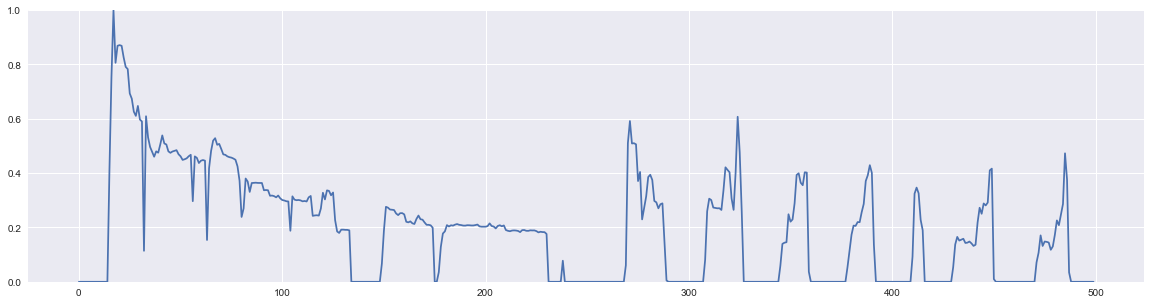

In [16]:
# Plotando as partes da serie para verificar se tá tudo bem
plt.figure(figsize=(20, 5))
plt.plot(serie_train)
plt.ylim(0, 1)
plt.show()

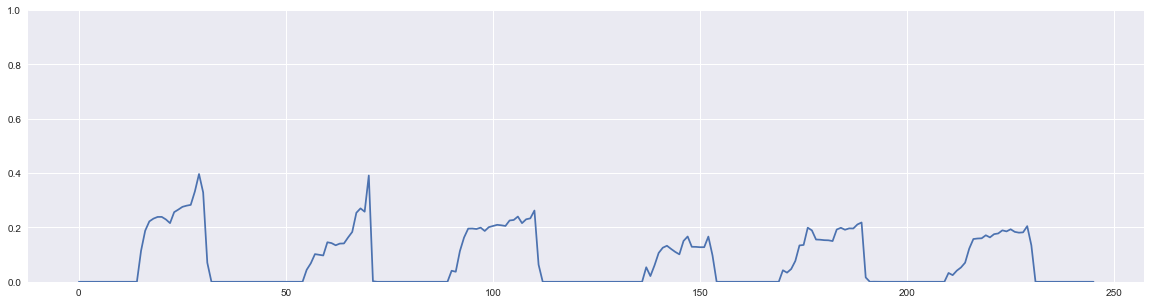

In [17]:
# Plotando as partes da serie para verificar se tá tudo bem
plt.figure(figsize=(20, 5))
plt.plot(serie_test)
plt.ylim(0, 1)
plt.show()

In [18]:
# Separanto a serie de treino em pedaços para treinamento do modelo
Xaux, Yaux = set_seq(serie_train, look_back, foward_days)

In [19]:
# Verificando quantos pedaços conseguimos dividir nossa serie
print(Xaux.shape, Yaux.shape)

(300, 100, 1) (300, 100, 1)


# LSTM

In [20]:
def power_element(base=2, power=0):
    a = 1
    for _ in range(power):
        a = a*base
    return a

In [21]:
for power in range(10):
    if power_element(2, power) > look_back:
        break

In [22]:
NUM_NEURONS_FirstLayer = power_element(2, power+2)
NUM_NEURONS_SecondLayer = power_element(2, power+1)
NUM_NEURONS_ThirdLayer = power_element(2, power)
EPOCHS = 50

print('NUM_NEURONS_FirstLayer:',NUM_NEURONS_FirstLayer,'\nNUM_NEURONS_SecondLayer:',NUM_NEURONS_SecondLayer,'\nNUM_NEURONS_ThirdLayer:',NUM_NEURONS_ThirdLayer,'\nEPOCHS:',EPOCHS)

NUM_NEURONS_FirstLayer: 512 
NUM_NEURONS_SecondLayer: 256 
NUM_NEURONS_ThirdLayer: 128 
EPOCHS: 50


In [23]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back, 1), return_sequences=True, activation='tanh'))#, kernel_initializer='random_normal'))
modelLSTM.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1), activation='tanh'))#, kernel_initializer='random_normal'))
modelLSTM.add(Dense(NUM_NEURONS_ThirdLayer))#, activation='tanh', kernel_initializer='random_normal'))
modelLSTM.add(Dense(foward_days))#, activation='tanh', kernel_initializer='random_normal'))

modelLSTM.compile(loss='mean_squared_error', optimizer='adam')

2022-09-22 06:26:49.603130: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
history = modelLSTM.fit(Xaux, Yaux, epochs=EPOCHS, shuffle=True, batch_size=2, verbose=2)

Epoch 1/50
150/150 - 53s - loss: 0.0223 - 53s/epoch - 351ms/step
Epoch 2/50
150/150 - 52s - loss: 0.0207 - 52s/epoch - 348ms/step
Epoch 3/50
150/150 - 48s - loss: 0.0200 - 48s/epoch - 320ms/step
Epoch 4/50
150/150 - 48s - loss: 0.0198 - 48s/epoch - 321ms/step
Epoch 5/50
150/150 - 48s - loss: 0.0199 - 48s/epoch - 318ms/step
Epoch 6/50
150/150 - 48s - loss: 0.0211 - 48s/epoch - 318ms/step
Epoch 7/50
150/150 - 48s - loss: 0.0202 - 48s/epoch - 322ms/step
Epoch 8/50
150/150 - 48s - loss: 0.0198 - 48s/epoch - 321ms/step
Epoch 9/50
150/150 - 48s - loss: 0.0197 - 48s/epoch - 318ms/step
Epoch 10/50
150/150 - 48s - loss: 0.0194 - 48s/epoch - 317ms/step
Epoch 11/50
150/150 - 48s - loss: 0.0193 - 48s/epoch - 320ms/step
Epoch 12/50
150/150 - 48s - loss: 0.0190 - 48s/epoch - 319ms/step
Epoch 13/50
150/150 - 48s - loss: 0.0187 - 48s/epoch - 319ms/step
Epoch 14/50
150/150 - 48s - loss: 0.0186 - 48s/epoch - 320ms/step
Epoch 15/50
150/150 - 48s - loss: 0.0185 - 48s/epoch - 319ms/step
Epoch 16/50
150/150

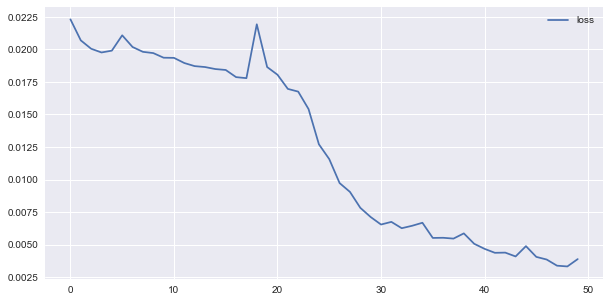

In [25]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label='loss')
plt.legend(loc='best')
plt.show()

# Verificando os dados de treino e teste

In [26]:
# Separando a serie completa em pedaços para verificarmos como ficou o treinamento do modelo
X, y = set_seq(serie, look_back, foward_days)

In [27]:
# Verificando quantos pedaços conseguimos dividir a série inteira
print(X.shape, y.shape)

(546, 100, 1) (546, 100, 1)


In [28]:
# # Fazendo o reshape, respeitando como input para o modelo RandomForest
# a, b, _ = X.shape
# X_ = X.reshape((a, b))

In [29]:
# Fazendo predições com o X_
Xt = modelLSTM.predict(X)

In [30]:
Xt.shape

(546, 100)

In [31]:
# Como queremos prever blocos de foward_days, retiramos todos que estão entre [forward_days, foward_days+i]
# Só queremos os múltiplos de foward_days
predLSTM = np.array([])
for i, a in enumerate(Xt):
    if np.mod(i, foward_days) == 0:
        predLSTM = np.append(predLSTM, a)

# predLSTM = np.array([a[0] for a in Xt])

In [32]:
predLSTM.shape

(600,)

In [33]:
# Verificando onde parar e quantas partes iremos dividir o eixo X (usando o linspace do numpy)
stop = 0
split = 1

while stop < len(serie):
    stop += foward_days
    split += 1

In [34]:
serie.shape[0] - predLSTM.shape[0] + look_back

246

In [35]:
# Fazendo append com zeros para fitar a curva bonitinho no início
aux = serie.shape[0] - predLSTM.shape[0] - look_back

predLSTM_ = np.append(np.zeros(serie.shape[0]-predLSTM.shape[0]-foward_days+aux), predLSTM)

In [36]:
# Verificando o último bloco de predição que não é multiplo de foward_days
a = serie.shape[0]-np.mod(serie.shape[0], foward_days)
last_pred_X = serie[(a-look_back):a]
last_pred_X = last_pred_X.reshape(1, look_back, 1)
last_pred = modelLSTM.predict(last_pred_X)

In [37]:
# Appendando o que foi predito com o último bloco de predição
predLSTM__ = np.append(predLSTM_, last_pred)

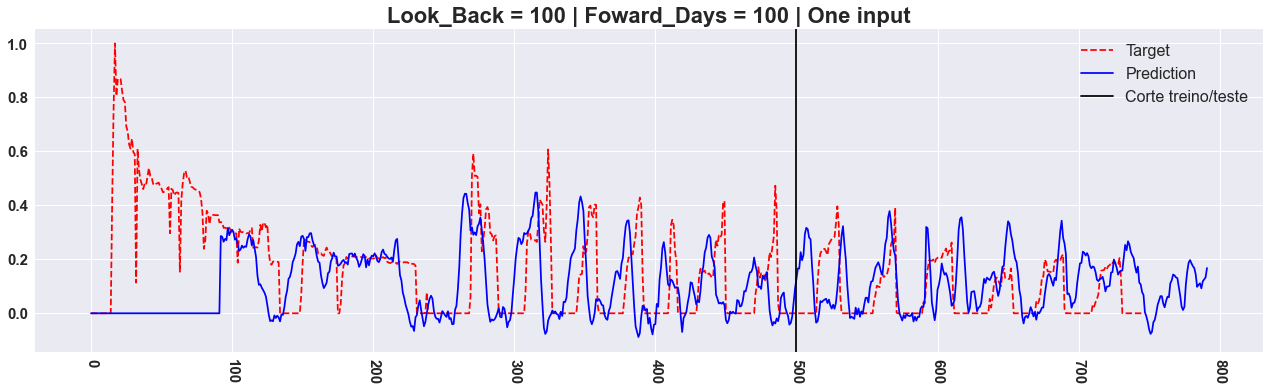

In [38]:
a = 22
plt.figure(figsize=(a, a*0.27))
# ser1 = scaler.inverse_transform(serie)
plt.plot(serie, 'r--', label='Target')
# ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(predLSTM__, 'b', label='Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
# plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
# plt.text(x=corte_teste-foward_days+50, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 50:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back = {} | Foward_Days = {} | One input'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 600)
plt.show()

# Processando o resultado abaixo de um threshold

In [39]:
thr

0.1

In [40]:
# Criando um array utilizando list_comprehension, transformando todos abaixo do thr em 0
lst = np.array([a if a > thr else 0 for a in predLSTM__]).reshape(-1, 1)

# lst = []
# for i in range(predRF__.shape[0]):
#     try:
#         if ser1[i] == 0:
#             lst.append(0)
#         else:
#             lst.append(predRF__[i])
            
#     except:
#         if predRF__[i] < thr:
#             lst.append(0)
#         else:
#             lst.append(predRF__[i])

# lst = np.array(lst)

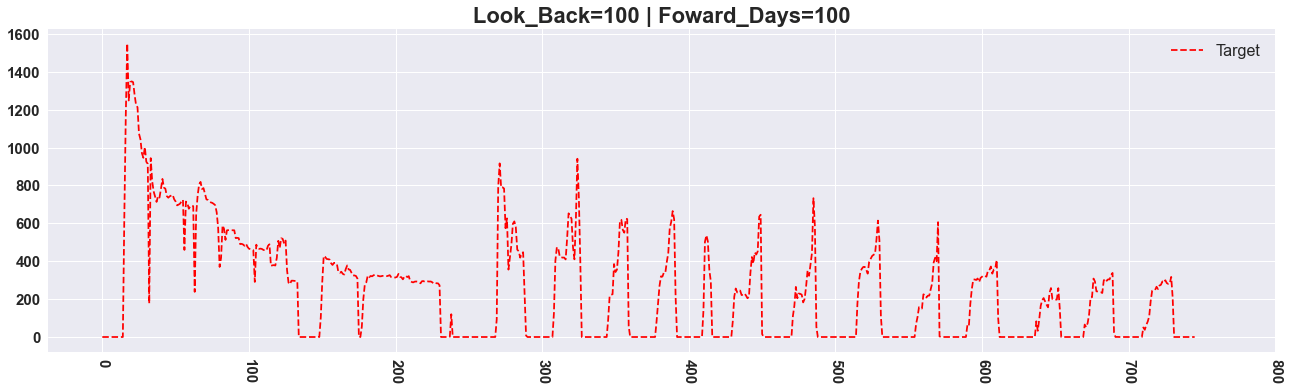

In [41]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 600)
plt.show()

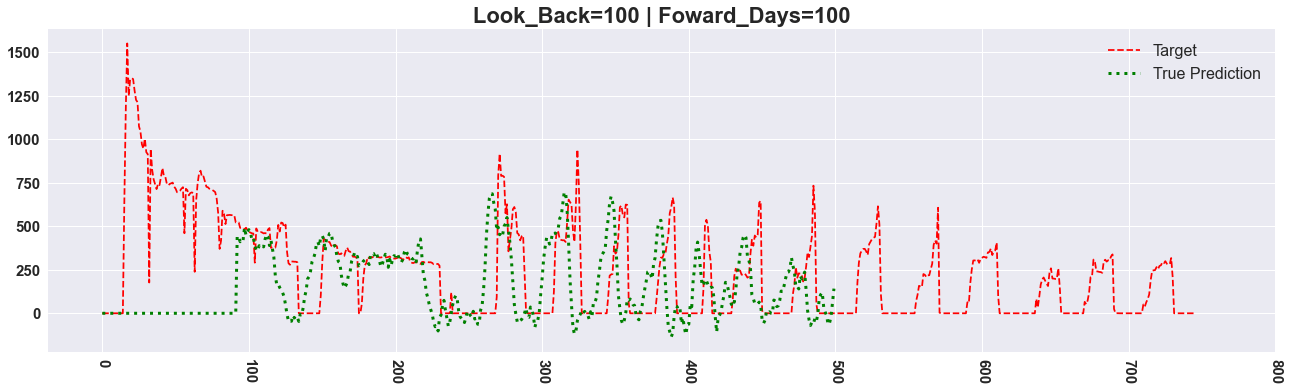

In [42]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(ser2[0:500:], 'g:',linewidth=3, label='True Prediction')

plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 600)
plt.show()

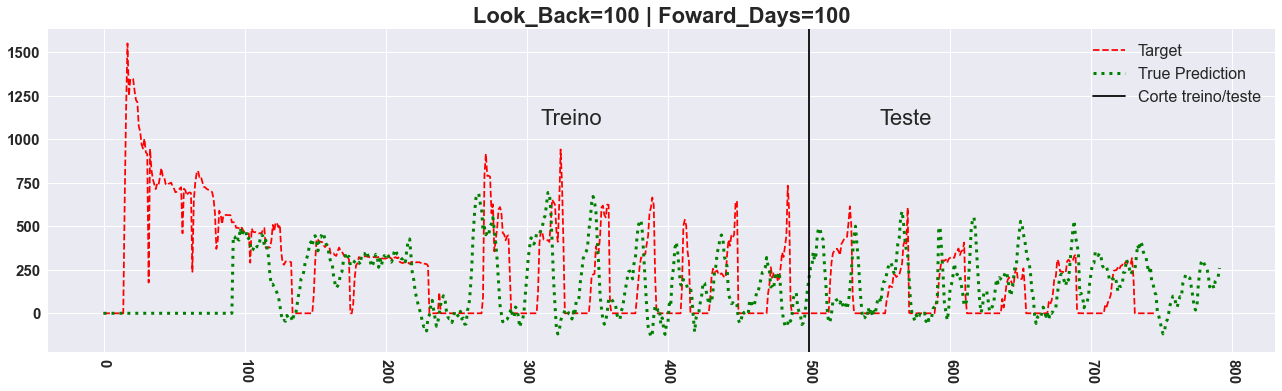

In [43]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'g:',linewidth=3, label='True Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+150, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
#plt.xlim(0, 799)
plt.show()

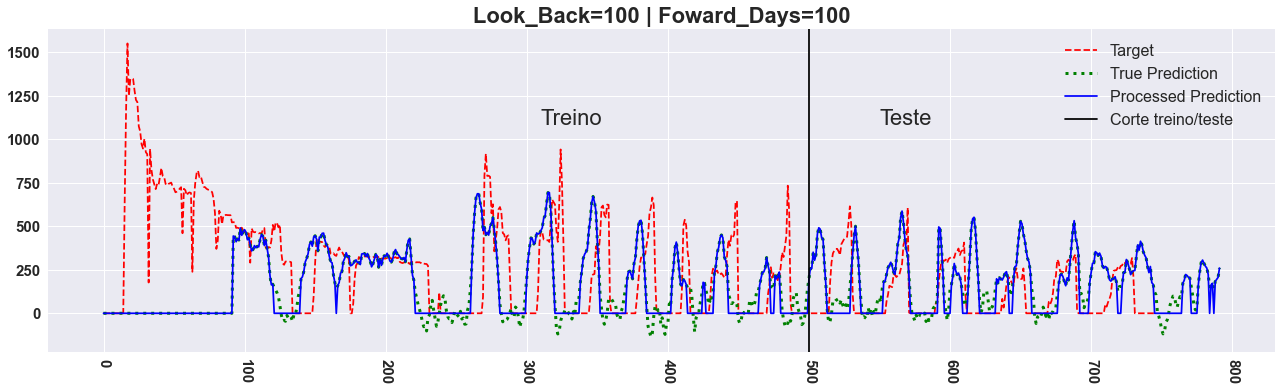

In [44]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'g:',linewidth=3, label='True Prediction')
ser3 = scaler.inverse_transform(lst.reshape(-1, 1))
plt.plot(ser3, 'b', label='Processed Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+150, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
#plt.xlim(0, 799)
plt.show()

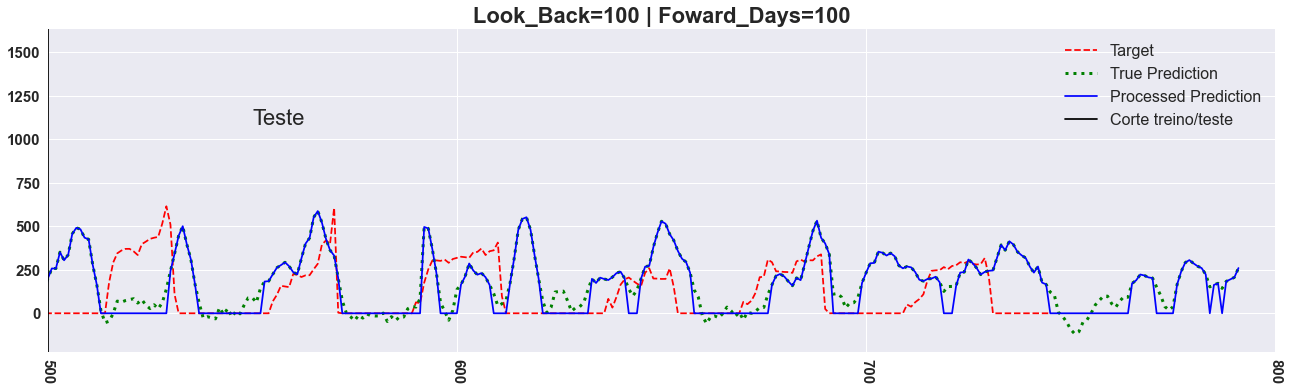

In [45]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'g:',linewidth=3, label='True Prediction')
ser3 = scaler.inverse_transform(lst.reshape(-1, 1))
plt.plot(ser3, 'b', label='Processed Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
#plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+150, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
plt.xlim(500, 800)
plt.show()

# Colocando os outputs como inputs

In [46]:
pred = predLSTM__[corte_teste:corte_teste+foward_days].reshape(1, look_back, 1) # Verificando o primeiro bloco de predição do modelo
new_pred = np.array([]) # Vetor vazio para appendarmos as novas predições

n_iterations = 2

for i in range(n_iterations):
    yy = modelLSTM.predict(pred) # Realiza a predição seguinte cutilizando como parametros a predição anterior
    new_pred = np.append(new_pred, yy) # Appendando o resultado no vetor new_pred
    pred = yy.reshape(1, look_back, 1) # Pegando o resultado da predição, reshapando para a RandomForest e storando no pred para uma nova rodada de predição

In [47]:
pred_train = predLSTM__[:corte_teste] # Pegando a validação do modelo com a parte do treino
new_predLSTM__ = np.append(pred_train, new_pred) # Appendando a parte do treino com a nova predição, utilizando os outputs anteriores como inputs para novas predições

In [48]:
# Verificando onde parar e quantas partes iremos dividir o eixo X (usando o linspace do numpy)
stop = 0
split = 1

while stop < new_predLSTM__.shape[0]:
    stop += foward_days
    split += 1

In [49]:
new_predLSTM__.shape

(700,)

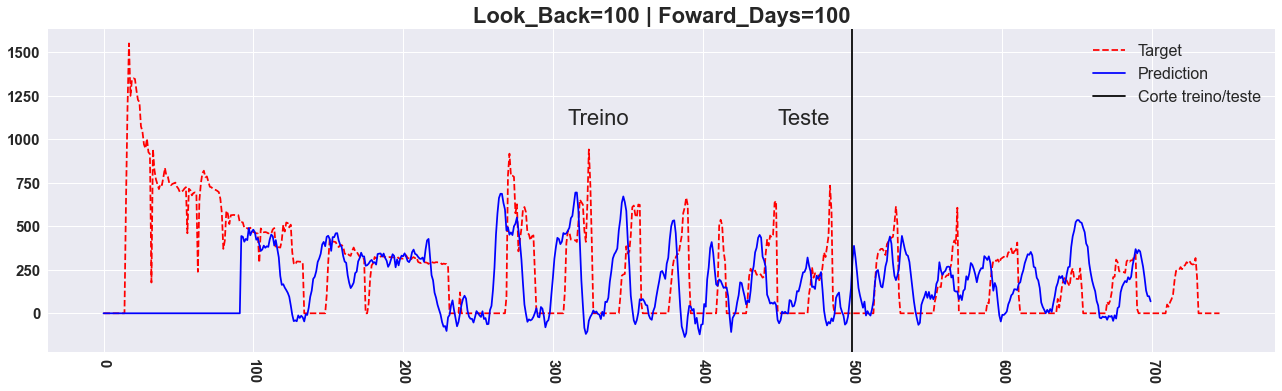

In [50]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'b', label='Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+50, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 900)
plt.show()

# Tratando todos abaixo de um threshold

In [51]:
# Criando um array utilizando list_comprehension, transformando todos abaixo do thr em 0
lst = np.array([a if a > thr else 0 for a in new_predLSTM__]).reshape(-1, 1)

# lst = []
# for i in range(new_predRF__.shape[0]):
#     try:
#         if ser1[i] == 0:
#             lst.append(0)
#         else:
#             lst.append(new_predRF__[i])
            
#     except:
#         if new_predRF__[i] < thr:
#             lst.append(0)
#         else:
#             lst.append(new_predRF__[i])

# lst = np.array(lst)

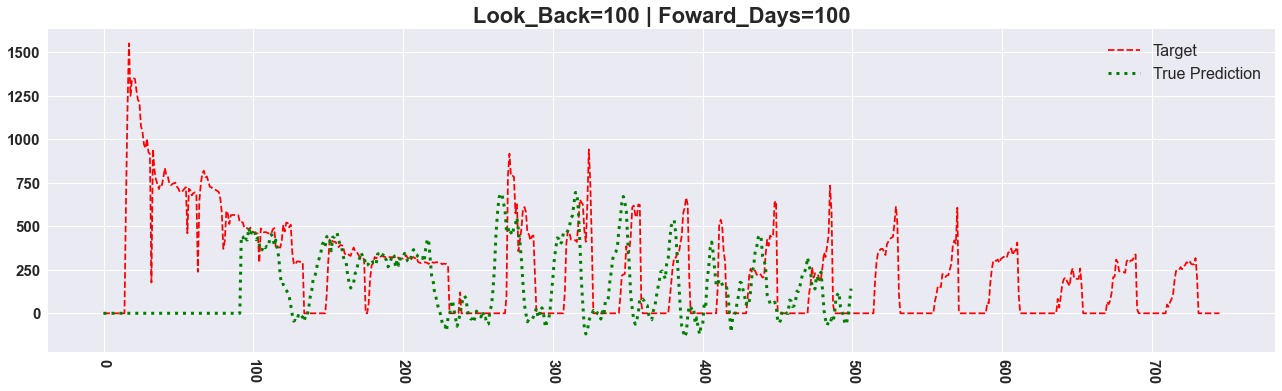

In [52]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(ser2[0:500:], 'g:',linewidth=3, label='True Prediction')


plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 900)
plt.show()

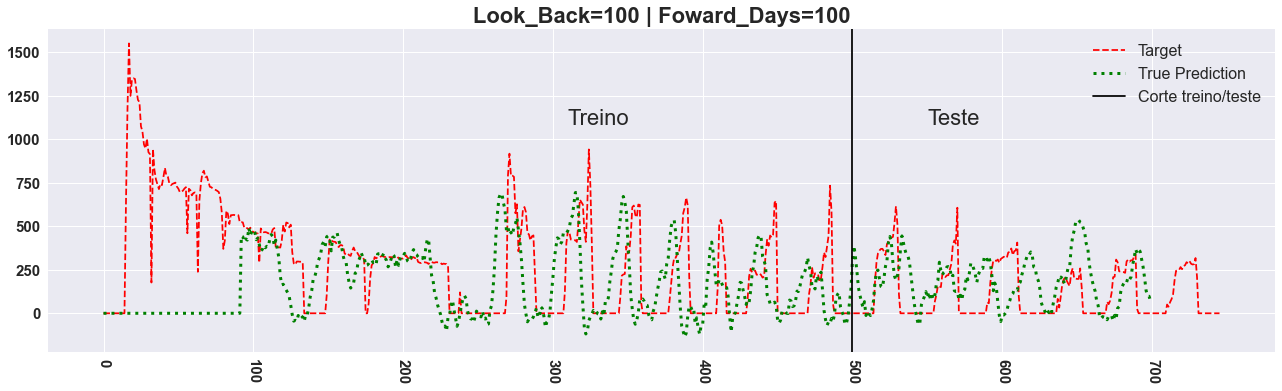

In [53]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'g:',linewidth=3, label='True Prediction')


plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+150, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 900)
plt.show()

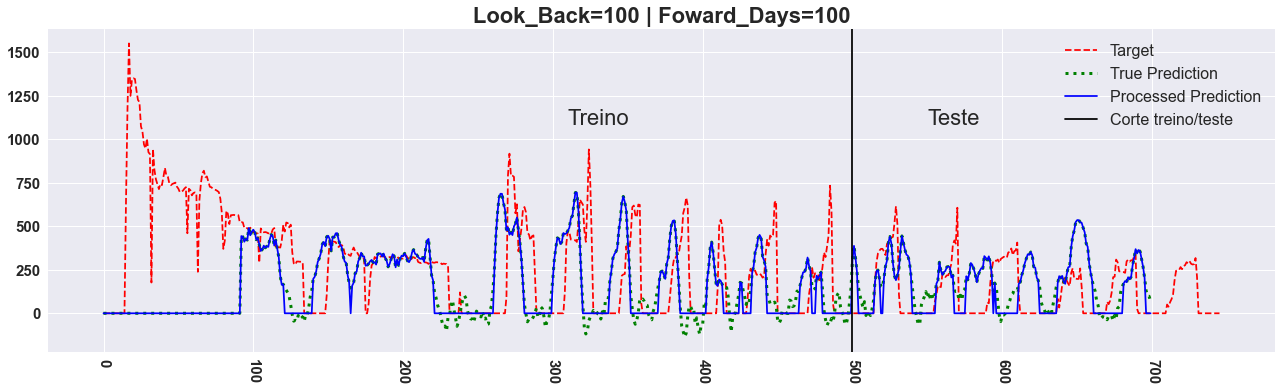

In [54]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'g:',linewidth=3, label='True Prediction')
ser3 = scaler.inverse_transform(lst.reshape(-1, 1))
plt.plot(ser3, 'b', label='Processed Prediction')
plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+150, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 900)
plt.show()

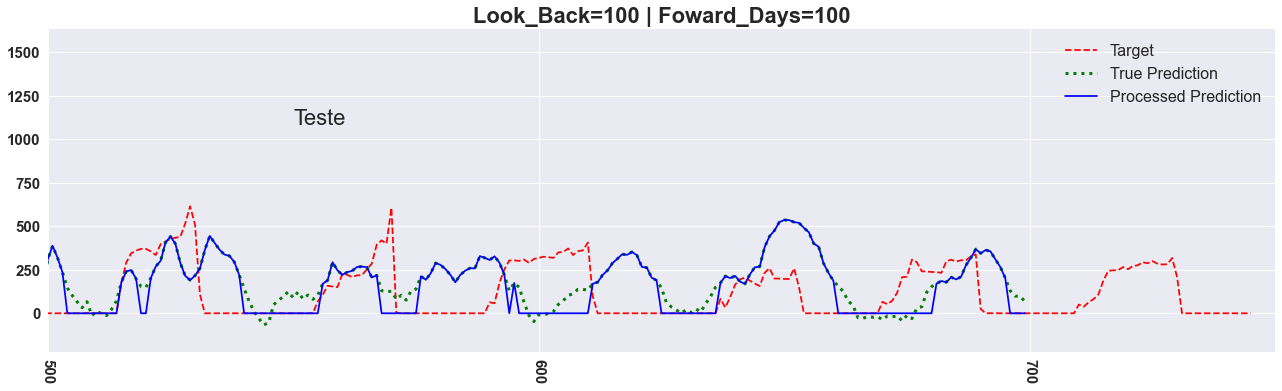

In [55]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'g:',linewidth=3, label='True Prediction')
ser3 = scaler.inverse_transform(lst.reshape(-1, 1))
plt.plot(ser3, 'b', label='Processed Prediction')
#plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
#plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+150, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
plt.xlim(500, 750)
plt.show()

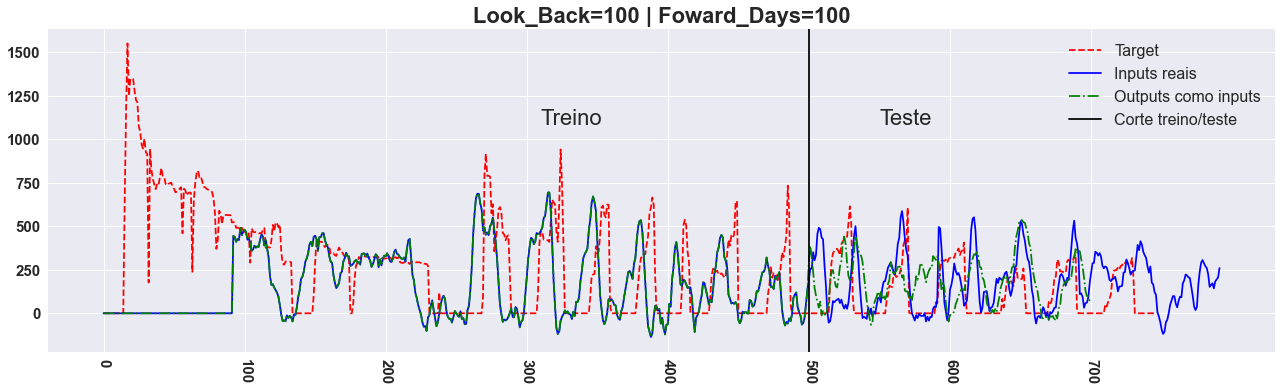

In [56]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'b', label='Inputs reais')

ser3 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(ser3, 'g-.', label='Outputs como inputs')

plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+150, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
# plt.xlim(0, 600)
plt.show()

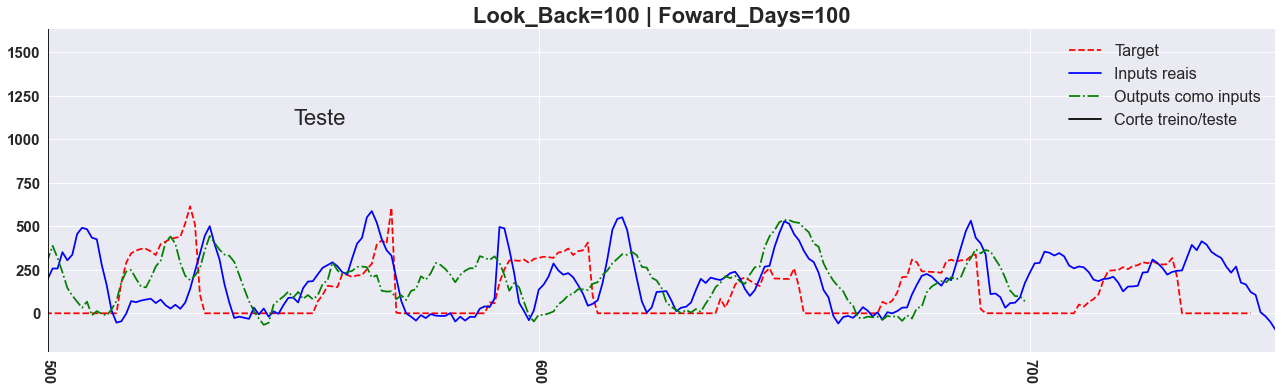

In [57]:
a = 22
plt.figure(figsize=(a, a*0.27))
ser1 = scaler.inverse_transform(serie)
plt.plot(ser1, 'r--', label='Target')
ser2 = scaler.inverse_transform(predLSTM__.reshape(-1, 1))
plt.plot(ser2, 'b', label='Inputs reais')

ser3 = scaler.inverse_transform(new_predLSTM__.reshape(-1, 1))
plt.plot(ser3, 'g-.', label='Outputs como inputs')

plt.axvline(x=corte_teste, color='k', label='Corte treino/teste')
#plt.text(x=corte_teste-foward_days-90, y=0.7*ser1.max(), s='Treino', fontsize=a)
plt.text(x=corte_teste-foward_days+150, y=0.7*ser1.max(), s='Teste', fontsize=a)
plt.legend(fontsize=16, loc='best')
if foward_days > 1:
    plt.xticks(np.linspace(0, stop, split), fontsize=15, fontweight='bold', rotation=270)
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Look_Back={} | Foward_Days={}'.format(look_back, foward_days), fontsize=a, fontweight='bold')
plt.xlim(500, 750)
plt.show()

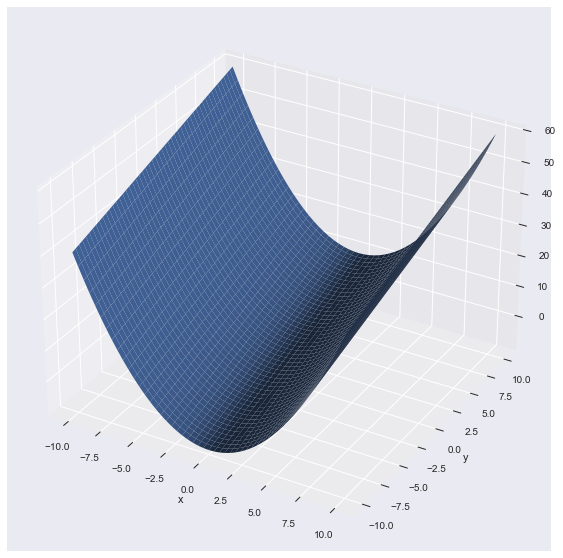

In [58]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# Creating dataset
xbar, ybar = 0, 0
ax, bx = xbar-10, xbar+10
ay, by = ybar-10, ybar+10
num = 1000
x = np.outer(np.linspace(ax, bx, num), np.ones(num))
y = np.outer(np.linspace(ay, by, num), np.ones(num)).T
# z = x * (1 - y)
z = 0.5*(x - xbar)**2 + y # 0.5*(y - ybar)**2
    
# Creating figure
fig = plt.figure(figsize =(10, 10))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x, y, z)
plt.xlabel('x')
plt.ylabel('y')
 
# show plot
plt.show()

In [59]:
x

array([[-10.        , -10.        , -10.        , ..., -10.        ,
        -10.        , -10.        ],
       [ -9.97997998,  -9.97997998,  -9.97997998, ...,  -9.97997998,
         -9.97997998,  -9.97997998],
       [ -9.95995996,  -9.95995996,  -9.95995996, ...,  -9.95995996,
         -9.95995996,  -9.95995996],
       ...,
       [  9.95995996,   9.95995996,   9.95995996, ...,   9.95995996,
          9.95995996,   9.95995996],
       [  9.97997998,   9.97997998,   9.97997998, ...,   9.97997998,
          9.97997998,   9.97997998],
       [ 10.        ,  10.        ,  10.        , ...,  10.        ,
         10.        ,  10.        ]])